In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees

# Arguments 

In [2]:
corr = 0.25
seq_length = 1000

# Load Model

In [ ]:
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze_bigger_models", "layer4")

epoch=36-val_loss=0.001347.ckpt


# Load Model

In [ ]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "tree_maze"
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
if corr == 0.25:
    model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.2_initseed0_batch512"
elif corr == 0.:
    model_name = "transformer_end_query_embd512_layer3_head4_lr1e-05_drop0_initseed1_batch256"
else:
    raise ValueError(f"Unknown correlation value: {corr}")
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)

eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr{corr}_state_dim10_envs1000_H1600_explore/datasets/eval.pkl"

epoch=31-val_loss=0.000400.ckpt


In [5]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [6]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

# Load Dataset and Create Environment

In [7]:
n_eval_envs = -1 #50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    if n_eval_envs != -1:
        eval_trajs = [eval_trajs[i] for i in traj_indices]
    else:
        n_eval_envs = len(traj_indices)
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    if n_eval_envs != -1:
        random.seed(0)
        eval_trajs = random.sample(eval_trajs, n_eval_envs)
        random.seed()
    else:
        n_eval_envs = len(eval_trajs)


In [8]:
def run_model(traj, model, seq_length=1200, start_idx=800):
    hidden_states = []

    batch = {
        'context_states': convert_to_tensor([np.array(traj['context_states'])]),
        'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
        'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
        'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
        'query_states': convert_to_tensor([np.array(traj['query_state'])]),  # Ignored
        }
    batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
    for k in batch.keys():
        if 'context' in k:
            batch[k] = batch[k][:,:seq_length]
        batch[k] = batch[k].to(model.device)
    model.save_activations = True
    with torch.no_grad():
        out = model(batch)
    _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers of (1, seq, dim)
    state_features = batch['context_states'][0][start_idx:].to('cpu').numpy()
    next_state_features = batch['context_next_states'][0][start_idx:].to('cpu').numpy()
    actions = batch['context_actions'][0].argmax(dim=1)[start_idx:].to('cpu').numpy()
    for i_layer in range(model.n_layer):
        hidden_states.append(_hidden_states[i_layer][0,start_idx:-1])
    return hidden_states, state_features, next_state_features, actions

# Across context decoding
(within-context is not that good)

In [9]:
def get_subtree_location(layer, pos, subtree):
    midpt = 2**(layer-1)
    quarter_pt = midpt//2
    eighth_pt = quarter_pt//2
    if layer == 0:
        return 0
    if subtree == 'half':
        return 1 if pos < midpt else 2
    elif subtree == 'quarter':
        if layer == 1:
            return 0
        bins = np.arange(0, 2**layer, quarter_pt)
        return np.digitize([pos], bins)[0]
    elif subtree == 'eighth':
        if (layer == 1) or (layer == 2):
            return 0
        bins = np.arange(0, 2**layer, eighth_pt)
        return np.digitize([pos], bins)[0]

    

In [10]:
def make_train_test_matrices():
    X = [[] for _ in range(model.n_layer)]
    Ys_dict = {
        "dist_from_goal": [],
        "layer": [],
        "node_identity": [],
        "maze_half": [],
        "maze_quarter": [],
        "maze_eighth": [],
        'is_goal': [],
        'same_half_as_goal': [],
        'same_quarter_as_goal': [],
        'opt_action': [],
        'state_feature': [],
        'next_state_feature': [],
        "on_path": [],
        "on_lr_path": [],
        "inverse_action": [],
        "action": []
    }
    for i_eval in range(n_eval_envs):
        onehot_env = np.zeros(n_eval_envs)
        onehot_env[i_eval] = 1
        traj = eval_trajs[i_eval]
        first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
        if (first_reward.size == 0) or (first_reward[0] > seq_length):
            continue
        start_idx = first_reward[0].item()

        env_config = {
            'max_layers': 7,
            'horizon': 1600,
            'branching_prob': 1.0,
            'node_encoding_corr': corr,
            'state_dim': state_dim,
            'initialization_seed': np.array(traj['initialization_seed']).item()
        }
        env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
        opt_action_map, dist_from_goal = env.make_opt_action_dict()

        hidden_states, state_features, next_state_features, actions = run_model(traj, model, seq_length, start_idx)
        goal_node = env.node_map[tuple(env.goal.tolist())]
        goal_layer = goal_node.layer
        goal_pos = goal_node.pos
        seen_combos = set()
        for state_idx, state_feature in enumerate(state_features):
            next_state_feature = next_state_features[state_idx]
            state_feature_tuple = tuple(state_feature.tolist())
            next_state_feature_tuple = tuple(next_state_feature.tolist())
            action = actions[state_idx]
            combo = tuple(state_feature.tolist() + next_state_feature.tolist())
            if combo in seen_combos:
                continue
            seen_combos.add(combo)
            d = dist_from_goal[next_state_feature_tuple]
            layer = env.node_map[next_state_feature_tuple].layer
            pos = env.node_map[next_state_feature_tuple].pos
            node_identity = 2**layer + pos
            maze_half = get_subtree_location(layer, pos, 'half')
            maze_quarter = get_subtree_location(layer, pos, 'quarter')
            maze_eighth = get_subtree_location(layer, pos, 'eighth')
            if action == 0:
                if env.node_map[next_state_feature_tuple].left == env.node_map[state_feature_tuple]:
                    inverse_action = 1
                elif env.node_map[next_state_feature_tuple].right == env.node_map[state_feature_tuple]:
                    inverse_action = 2
                else:
                    inverse_action = -1
            elif action == 1 or action == 2:
                inverse_action = 0
            else:
                inverse_action = 3
            
            Ys_dict["dist_from_goal"].append(d)
            Ys_dict["layer"].append(layer)
            Ys_dict["node_identity"].append(node_identity)
            Ys_dict["maze_half"].append(maze_half)
            Ys_dict["maze_quarter"].append(maze_quarter)
            Ys_dict["maze_eighth"].append(maze_eighth)
            Ys_dict["is_goal"].append(state_feature_tuple == tuple(env.goal.tolist()))
            Ys_dict["same_half_as_goal"].append(maze_half == get_subtree_location(goal_layer, goal_pos, 'half'))
            Ys_dict["same_quarter_as_goal"].append(maze_quarter == get_subtree_location(goal_layer, goal_pos, 'quarter'))
            Ys_dict["opt_action"].append(opt_action_map[state_feature_tuple])
            Ys_dict["state_feature"].append(state_feature)
            Ys_dict["next_state_feature"].append(next_state_feature)
            Ys_dict["on_path"].append(action == opt_action_map[state_feature_tuple])
            Ys_dict["on_lr_path"].append(
                (action == opt_action_map[state_feature_tuple]) and
                (action in [1, 2])
                )
            Ys_dict["inverse_action"].append(inverse_action)
            Ys_dict["action"].append(action)
            
            for layer in range(model.n_layer):
                hidden_state = hidden_states[layer][state_idx].to('cpu').numpy()
                hidden_state = np.concatenate([hidden_state, onehot_env])
                X[layer].append(hidden_state)
        torch.cuda.empty_cache()

    test_size = 0.1
    test_start_idx = int(len(X[0])*(1-test_size))
    all_indices = np.arange(len(X[0]))
    np.random.shuffle(all_indices)
    train_indices = all_indices[:test_start_idx]
    test_indices = all_indices[test_start_idx:]

    X_train = [[] for _ in range(model.n_layer)]
    X_test = [[] for _ in range(model.n_layer)]
    Ys_dict_train_test = {key: {'Y_train': [], 'Y_test': []} for key in Ys_dict}
    # Use same indices for all layers to keep corresponding samples together
    for layer, layer_data in enumerate(X):
        X_train[layer] = [layer_data[i] for i in train_indices]
        X_test[layer] = [layer_data[i] for i in test_indices]
    for key in Ys_dict:
        Ys_dict_train_test[key]['Y_train'] = [Ys_dict[key][i] for i in train_indices]
        Ys_dict_train_test[key]['Y_test'] = [Ys_dict[key][i] for i in test_indices]
    return X_train, X_test, Ys_dict_train_test

In [11]:
import warnings

from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

def fit_and_evaluate_regression(X_train, Y_train, X_test, Y_test, print_scores=True):
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import Ridge
    
    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    alphas = np.logspace(0, 4, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, alpha):
        # Train on this fold
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        # Get validation score
        val_score = pipeline.score(X[val_idx], y[val_idx])
        return val_score

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)-1):
        # Parallel CV for each alpha
        cv_scores = {alpha: [] for alpha in alphas}
        for alpha in alphas:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, alpha
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[alpha] = np.mean(scores)
        
        # Find best alpha
        best_alpha = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best alpha
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        train_score = pipeline.score(X_train_np[layer], Y_train_np)
        test_score = pipeline.score(X_test_np[layer], Y_test_np)
        
        pipelines.append(pipeline)
        test_scores.append(test_score)
        
        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best alpha: {best_alpha:.3f}")
            print(f"Train R2: {train_score:.3f}")
            print(f"Test R2: {test_score:.3f}")
            print()

            y_pred = pipeline.predict(X_test_np[layer])
            plt.figure(figsize=(4, 4))
            plt.scatter(Y_test_np, y_pred, alpha=0.5)
            plt.plot([Y_test_np.min(), Y_test_np.max()], [Y_test_np.min(), Y_test_np.max()], 'r--')
            plt.xlabel('True Values')
            plt.ylabel('Predictions')
            plt.title(f'Layer {layer}: True vs Predicted Values')
            plt.tight_layout()
            plt.show()
            
    return pipelines, test_scores

def fit_and_evaluate_classification(X_train, Y_train, X_test, Y_test, print_scores=True):
    import warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    Cs = np.logspace(-3, 3, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, C):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        y_val_pred = pipeline.predict(X[val_idx])
        # Use balanced accuracy score instead of regular accuracy
        return balanced_accuracy_score(y[val_idx], y_val_pred)

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)-1):
        # Parallel CV for each C value
        cv_scores = {C: [] for C in Cs}
        for C in Cs:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, C
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[C] = np.mean(scores)
        
        # Find best C
        best_C = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best C
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=best_C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        y_train_pred = pipeline.predict(X_train_np[layer])
        y_test_pred = pipeline.predict(X_test_np[layer])
        
        # Use balanced metrics
        train_accuracy = balanced_accuracy_score(Y_train_np, y_train_pred)
        test_accuracy = balanced_accuracy_score(Y_test_np, y_test_pred)
        train_f1 = f1_score(Y_train_np, y_train_pred, average='weighted')
        test_f1 = f1_score(Y_test_np, y_test_pred, average='weighted')

        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best C: {best_C:.3f}")
            print(f"Train Balanced Accuracy: {train_accuracy:.3f}")
            print(f"Test Balanced Accuracy: {test_accuracy:.3f}")
            print(f"Train Weighted F1: {train_f1:.3f}")
            print(f"Test Weighted F1: {test_f1:.3f}")
            # Add class distribution information
            print("Class distribution:")
            for cls in np.unique(Y_train_np):
                print(f"Class {cls}: {np.sum(Y_train_np == cls)} samples")
            print()

            # Add confusion matrix visualization
            y_test_pred = pipeline.predict(X_test_np[layer])
            cm = confusion_matrix(Y_test_np, y_test_pred)
            plt.figure(figsize=(5, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Layer {layer}: Confusion Matrix')
            plt.tight_layout()
            plt.show()
            
            print()

    return pipelines, test_scores

In [12]:
X_train, X_test, Ys_dict = make_train_test_matrices()

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Layer 0:
Best C: 0.100
Train Balanced Accuracy: 0.864
Test Balanced Accuracy: 0.768
Train Weighted F1: 0.868
Test Weighted F1: 0.852
Class distribution:
Class False: 10259 samples
Class True: 1101 samples



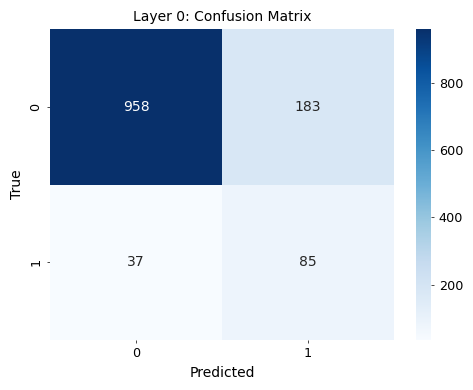


Layer 1:
Best C: 0.022
Train Balanced Accuracy: 0.962
Test Balanced Accuracy: 0.917
Train Weighted F1: 0.952
Test Weighted F1: 0.935
Class distribution:
Class False: 10259 samples
Class True: 1101 samples



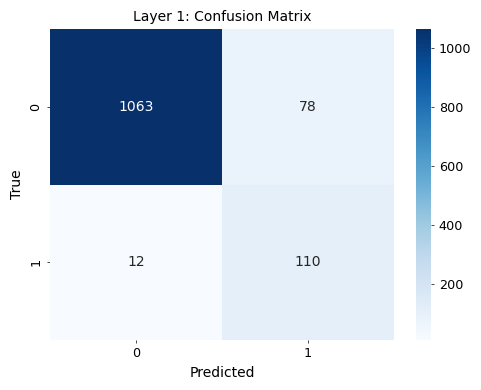

In [13]:
_Y_train = [a in [1, 2] for a in Ys_dict['opt_action']["Y_train"]]
_Y_test = [a in [1, 2] for a in Ys_dict['opt_action']["Y_test"]]
pipeline, test_score = fit_and_evaluate_classification(
    X_train, _Y_train, X_test, _Y_test)

Layer 0:
Best C: 0.001
Train Balanced Accuracy: 0.636
Test Balanced Accuracy: 0.593
Train Weighted F1: 0.636
Test Weighted F1: 0.593
Class distribution:
Class 1: 2005 samples
Class 2: 2006 samples



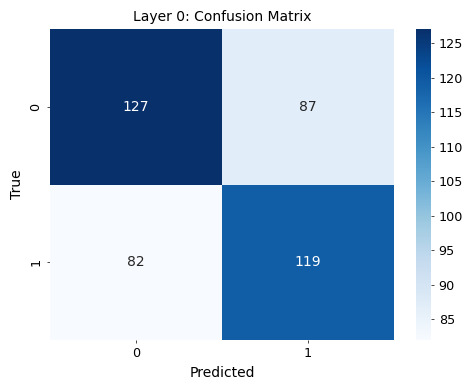


Layer 1:
Best C: 2.154
Train Balanced Accuracy: 0.838
Test Balanced Accuracy: 0.739
Train Weighted F1: 0.838
Test Weighted F1: 0.740
Class distribution:
Class 1: 2005 samples
Class 2: 2006 samples



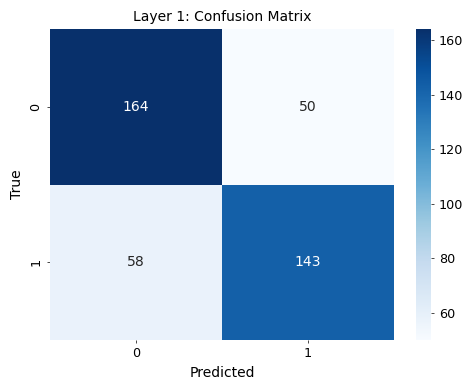

In [14]:
valid_train_idxs = [
    i for i in np.arange(len(Ys_dict['inverse_action']["Y_train"]))
    if Ys_dict['inverse_action']["Y_train"][i] in [1, 2]
]
valid_test_idxs = [
    i for i in np.arange(len(Ys_dict['inverse_action']["Y_test"]))
    if Ys_dict['inverse_action']["Y_test"][i] in [1, 2]
]
_X_train = [[X[i] for i in valid_train_idxs] for X in X_train]
_X_test = [[X[i] for i in valid_test_idxs] for X in X_test]
_Y_train = [Ys_dict['inverse_action']["Y_train"][i] for i in valid_train_idxs]
_Y_test = [Ys_dict['inverse_action']["Y_test"][i] for i in valid_test_idxs]
pipeline, test_score = fit_and_evaluate_classification(
    _X_train, _Y_train, _X_test, _Y_test)

Layer 0:
Best C: 0.100
Train Balanced Accuracy: 0.758
Test Balanced Accuracy: 0.757
Train Weighted F1: 0.766
Test Weighted F1: 0.761
Class distribution:
Class False: 7457 samples
Class True: 3903 samples



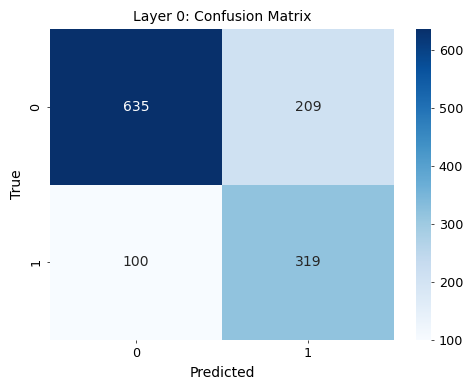


Layer 1:
Best C: 0.100
Train Balanced Accuracy: 0.850
Test Balanced Accuracy: 0.838
Train Weighted F1: 0.858
Test Weighted F1: 0.843
Class distribution:
Class False: 7457 samples
Class True: 3903 samples



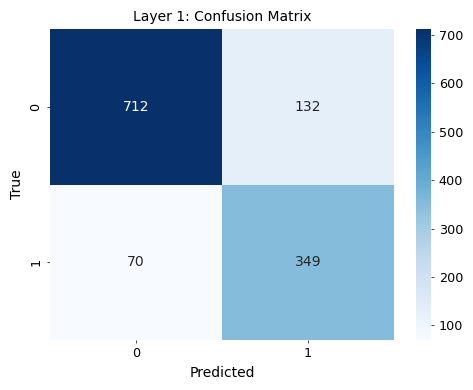

In [15]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["same_quarter_as_goal"]["Y_train"], X_test, Ys_dict["same_quarter_as_goal"]["Y_test"])

Layer 0:
Best C: 0.464
Train Balanced Accuracy: 0.763
Test Balanced Accuracy: 0.721
Train Weighted F1: 0.759
Test Weighted F1: 0.718
Class distribution:
Class False: 4629 samples
Class True: 6731 samples



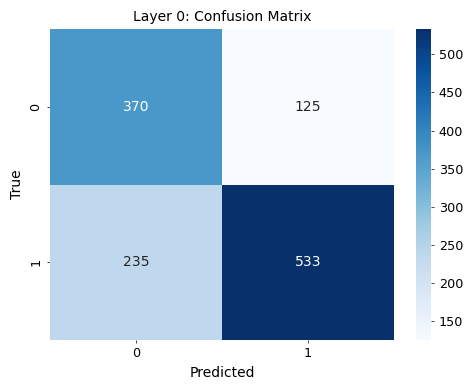


Layer 1:
Best C: 0.464
Train Balanced Accuracy: 0.839
Test Balanced Accuracy: 0.807
Train Weighted F1: 0.834
Test Weighted F1: 0.801
Class distribution:
Class False: 4629 samples
Class True: 6731 samples



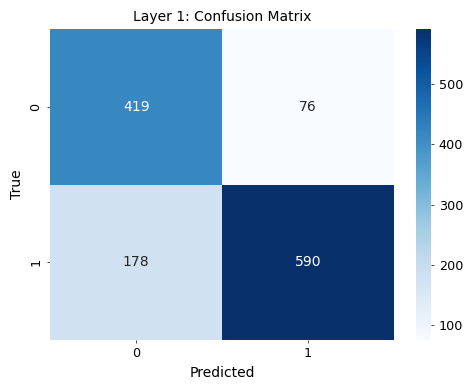

In [16]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["same_half_as_goal"]["Y_train"], X_test, Ys_dict["same_half_as_goal"]["Y_test"])

Layer 0:
Best C: 0.100
Train Balanced Accuracy: 0.751
Test Balanced Accuracy: 0.731
Train Weighted F1: 0.770
Test Weighted F1: 0.762
Class distribution:
Class False: 8194 samples
Class True: 3166 samples



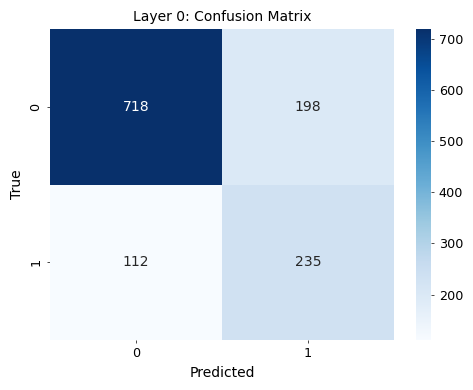


Layer 1:
Best C: 0.100
Train Balanced Accuracy: 0.850
Test Balanced Accuracy: 0.821
Train Weighted F1: 0.861
Test Weighted F1: 0.833
Class distribution:
Class False: 8194 samples
Class True: 3166 samples



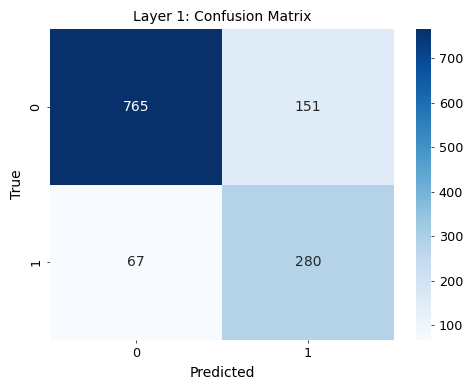

In [17]:
pipeline, test_score = fit_and_evaluate_classification(
    X_train,
    [y <= 6 for y in Ys_dict["dist_from_goal"]["Y_train"]],
    X_test,
    [y <= 6 for y in Ys_dict["dist_from_goal"]["Y_test"]]
    )

Layer 0:
Best C: 0.100
Train Balanced Accuracy: 0.825
Test Balanced Accuracy: 0.731
Train Weighted F1: 0.871
Test Weighted F1: 0.858
Class distribution:
Class False: 10371 samples
Class True: 989 samples



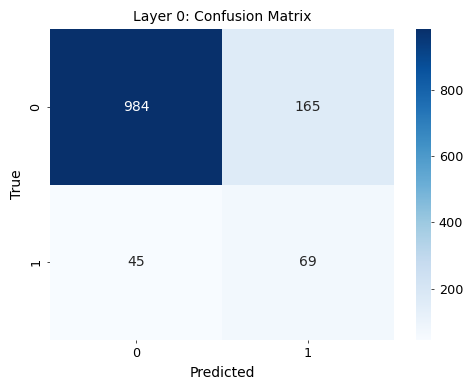


Layer 1:
Best C: 0.022
Train Balanced Accuracy: 0.920
Test Balanced Accuracy: 0.900
Train Weighted F1: 0.939
Test Weighted F1: 0.933
Class distribution:
Class False: 10371 samples
Class True: 989 samples



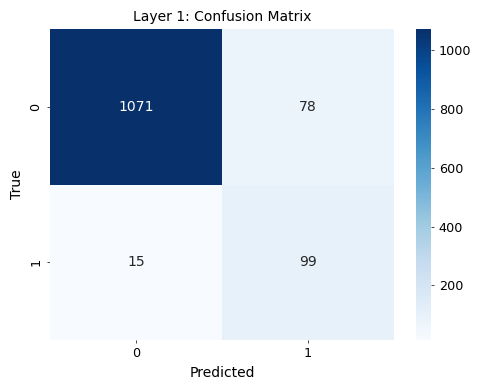

In [18]:
pipeline, test_score = fit_and_evaluate_classification(
    X_train,
    [y <= 3 for y in Ys_dict["dist_from_goal"]["Y_train"]],
    X_test,
    [y <= 3 for y in Ys_dict["dist_from_goal"]["Y_test"]]
    )

Layer 0:
Best C: 0.022
Train Balanced Accuracy: 0.848
Test Balanced Accuracy: 0.818
Train Weighted F1: 0.830
Test Weighted F1: 0.807
Class distribution:
Class False: 7774 samples
Class True: 3586 samples



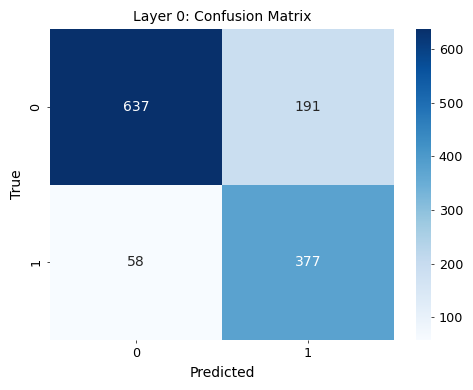


Layer 1:
Best C: 0.100
Train Balanced Accuracy: 0.908
Test Balanced Accuracy: 0.886
Train Weighted F1: 0.898
Test Weighted F1: 0.885
Class distribution:
Class False: 7774 samples
Class True: 3586 samples



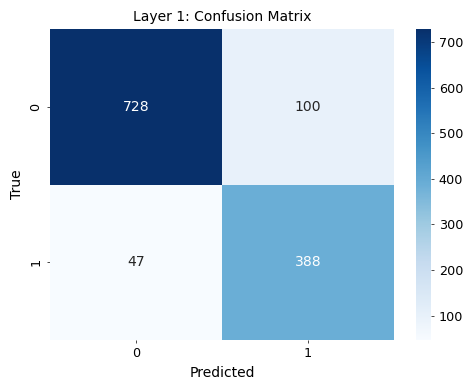

In [19]:
pipeline, test_score = fit_and_evaluate_classification(
    X_train,
    [y == 6 for y in Ys_dict["layer"]["Y_train"]],
    X_test,
    [y == 6 for y in Ys_dict["layer"]["Y_test"]])

Layer 0:
Best C: 2.154
Train Balanced Accuracy: 0.661
Test Balanced Accuracy: 0.341
Train Weighted F1: 0.621
Test Weighted F1: 0.498
Class distribution:
Class 0: 131 samples
Class 1: 324 samples
Class 2: 630 samples
Class 3: 1119 samples
Class 4: 1984 samples
Class 5: 3586 samples
Class 6: 3586 samples



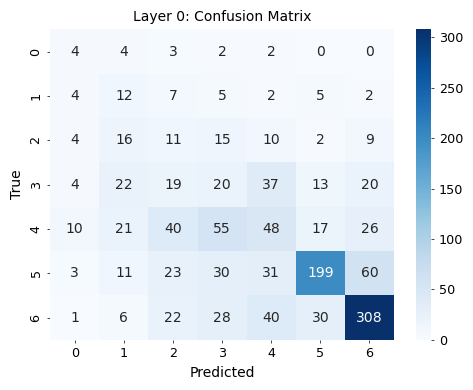


Layer 1:
Best C: 0.022
Train Balanced Accuracy: 0.717
Test Balanced Accuracy: 0.501
Train Weighted F1: 0.697
Test Weighted F1: 0.630
Class distribution:
Class 0: 131 samples
Class 1: 324 samples
Class 2: 630 samples
Class 3: 1119 samples
Class 4: 1984 samples
Class 5: 3586 samples
Class 6: 3586 samples



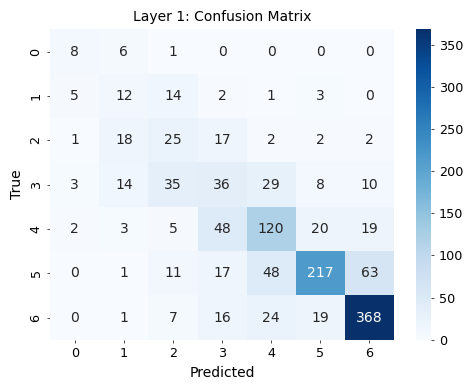

In [20]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["layer"]["Y_train"], X_test, Ys_dict["layer"]["Y_test"])

Layer 0:
Best C: 0.001
Train Balanced Accuracy: 0.736
Test Balanced Accuracy: 0.656
Train Weighted F1: 0.659
Test Weighted F1: 0.655
Class distribution:
Class 0: 131 samples
Class 1: 5417 samples
Class 2: 5812 samples



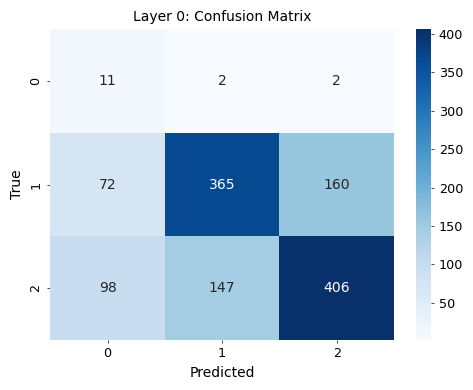


Layer 1:
Best C: 0.001
Train Balanced Accuracy: 0.804
Test Balanced Accuracy: 0.756
Train Weighted F1: 0.718
Test Weighted F1: 0.710
Class distribution:
Class 0: 131 samples
Class 1: 5417 samples
Class 2: 5812 samples



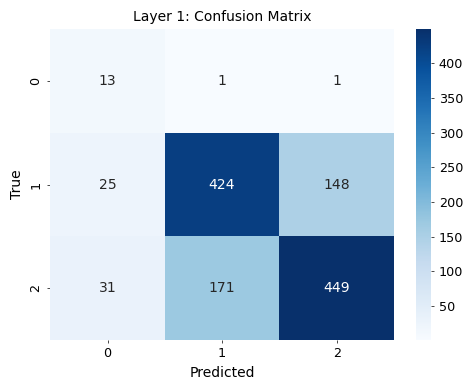

In [21]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["maze_half"]["Y_train"], X_test, Ys_dict["maze_half"]["Y_test"])